<a href="https://colab.research.google.com/github/phantomer-ai/AIFFEL_quest_cr/blob/main/Computer%20Vision%20Project2-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip3 install tensorflow-estimator==2.6.0

In [18]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [19]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [20]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [21]:
def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  for display_str in display_str_list[::-1]:  #최신버전 getbbox()로 변경
    bbox = font.getbbox(display_str)  # getsize() 대신 getbbox() 사용
    text_width = bbox[2] - bbox[0]  # bbox의 가로 길이
    text_height = bbox[3] - bbox[1]  # bbox의 세로 길이

    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [46]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i].item() >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmp7vdqjhpl.jpg.


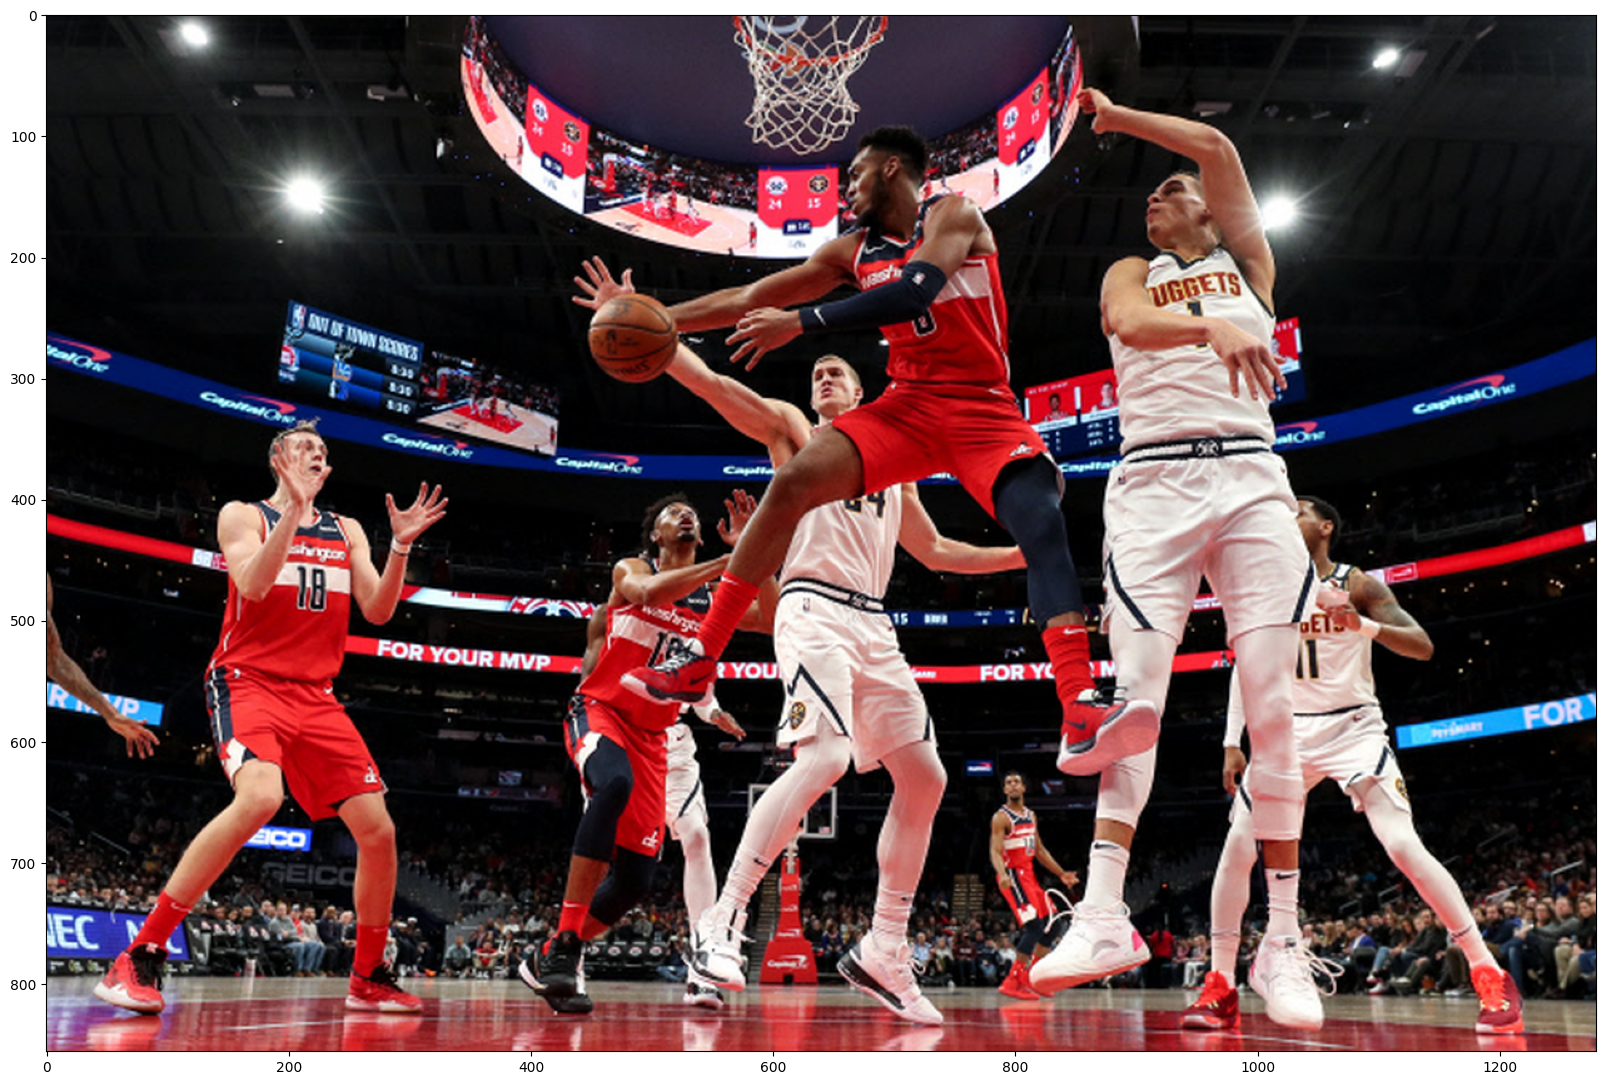

In [47]:
image_url = "https://news.nateimg.co.kr/orgImg/kz/2020/12/22/l_2020122202001145200216001.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.


In [48]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  # Replace Image.ANTIALIAS with Image.Resampling.LANCZOS
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.Resampling.LANCZOS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [49]:

# module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"  # SSD MobileNet V2
module_handle = "https://tfhub.dev/tensorflow/efficientdet/d0/1"  # EfficientDet D0
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  # Faster R-CNN (기본값)


#detector = hub.load(module_handle).signatures['default'] # Faster R-CNN (기본값)
detector = hub.load(module_handle).signatures['serving_default'] # detector에 사용할 모듈 저장

In [50]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [51]:
def run_detector(detector, path):
  img = load_img(path)

  #converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  converted_img = tf.expand_dims(img, axis=0)  # 배치 차원 추가
  converted_img = tf.cast(converted_img, tf.uint8)  # float32 → uint8 변환

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_classes"], result["detection_scores"])

  display_image(image_with_boxes)

In [52]:
run_detector(detector, downloaded_image_path)

Found 1 objects.
Inference time:  4.608861923217773


ValueError: can only convert an array of size 1 to a Python scalar

 TypeError: too many positional arguments & InvalidArgumentError 해결 방법
이 오류는 모델이 예상하는 입력 데이터 타입과 우리가 제공한 데이터 타입이 일치하지 않아서 발생합니다.
즉, 모델은 uint8 타입의 텐서를 기대하지만, 우리는 float32 타입의 데이터를 전달하고 있습니다.


해결 방법

tf.image.convert_image_dtype(img, tf.float32) 대신 uint8로 변환해야 합니다.
기존 코드에서 converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] 부분을 수정하면 해결됩니다.

WARNING: Importing a function with ops with unsaved custom gradients 해결 방법

-> 무시해도됨


 InvalidArgumentError: expected uint8 tensor but got float tensor 해결 방법
이 오류는 모델이 uint8 타입의 입력을 기대하지만, float32 형식의 텐서가 전달되어 발생하는 문제입니다.


해결 방법은 모델이 요구하는 uint8로 변환하는 것입니다.

🔹 (1) tf.cast()를 사용하여 uint8로 변환
python
복사
편집
converted_img = tf.cast(converted_img, tf.uint8)  # float32 → uint8 변환
🔹 (2) tf.image.convert_image_dtype()에서 uint8로 변환



KeyError: 'detection_class_entities'

✅ 2. 해결 방법
사용하는 모델에 따라 detection_class_entities 또는 detection_classes를 선택하도록 코드 수정

🔹 (1) result.keys()를 확인하고 적절한 키 선택
python



 ValueError: The truth value of an array with more than one element is ambiguous 해결 방법
이 오류는 NumPy 배열을 조건문에서 직접 사용했기 때문에 발생합니다.
예를 들어, if scores[i]:와 같은 코드를 사용할 경우 NumPy 배열이 여러 개의 요소를 포함하고 있어서 조건 평가가 모호해지는 문제가 발생합니다.


✅ 3. 결론
✔ 오류 원인: scores[i]가 NumPy 배열일 가능성이 있어 직접 비교 불가능
✔ 해결 방법: if float(scores[i]) >= min_score: 또는 if scores[i].item() >= min_score: 사용
✔ 이제 EfficientDet D0 모델이 정상적으로 실행됨! 🚀

이제 다시 실행해보세요! 😊


ValueError: can only convert an array of size 1 to a Python scalar 해결 방법
이 오류는 scores[i]가 단일 값이 아닌 NumPy 배열(크기가 1 이상인 배열)이기 때문에 발생합니다.
👉 즉, scores[i]가 여러 값을 포함하고 있어서 float 변환이 모호한 경우 발생하는 오류입니다.

같은오류 반복..............
포기

